<a href="https://colab.research.google.com/github/amittal-tcd/TCD-work/blob/master/Text%20Analytics/Step2%20-%20Model%20Improvement%20and%20Feature%20Importances/Text_Analytics_Group_6_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries
Need to run only once in a session


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install catboost
!pip install shap
!pip install wordfreq

# !pip install xgboost

!git clone https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package

## Import libraries
And download corpus which may only be done once in a session

In [0]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
import seaborn as sns
dest = ''
import shap
from difflib import get_close_matches
from sklearn.decomposition import PCA
import io
import requests

from wordfreq import word_frequency
from wordfreq import zipf_frequency

import warnings
warnings.filterwarnings('ignore')
np.random.seed(100)

nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Download Data from GIT and Keep Required Fields Only

In [0]:
url = "https://github.com/amittal-tcd/TCD-work/raw/master/Text%20Analytics/Step2%20-%20Model%20Improvement%20and%20Feature%20Importances/Data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(url)

df2 = df[['reviews.rating','reviews.text','reviews.title','reviews.date']]

df2.head()

,reviews.rating,reviews.text,reviews.title,reviews.date
0,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,2017-03-02T00:00:00.000Z
1,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z
2,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z
3,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z
4,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z


## Add POS Columns, Sentence Count

In [0]:
################ POS #################
POSCols = ['CC',	'CD',	'DT',	'EX',	'FW',	'IN',	'JJ',	'JJR',	'JJS',	'LS',	'MD',	'NN',	'NNP',	'NNPS',	'NNS',	'PDT',	'POS',	'PRP',	'PRP$',	'RB',	'RBR',	'RBS',	'RP',	'SYM',	'TO',	'UH',	'VB',	'VBD',	'VBG',	'VBN',	'VBP',	'VBZ',	'WDT',	'WP',	'WP$',	'WRB']
df2['reviews.text.POS'] = df2['reviews.text'].map(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
l = []
for i in list(df2['reviews.text.POS']):
  d = {}
  for j in i:
    if j[1] not in d:
      d[j[1]] = 0
    else:
      d[j[1]] += 1
  l.append(d)
df2['reviews.POS.dict'] = np.array(l)
for i in POSCols:
  df2[i] = df2['reviews.POS.dict'].map(lambda x: x[i] if i in x else 0)
  df2[i] = np.where(df2[i].isnull(),0,df2[i])

############### Sentence Count ##################
df2['sentence_count'] = df2.apply(lambda row: len(nltk.sent_tokenize(row['reviews.text'])) , axis = 1) 

df2.head()

,reviews.rating,reviews.text,reviews.title,reviews.date,reviews.text.POS,reviews.POS.dict,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,sentence_count
0,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,2017-03-02T00:00:00.000Z,"[(I, PRP), (order, NN), (3, CD), (of, IN), (th...","{'PRP': 2, 'NN': 8, 'CD': 1, 'IN': 2, 'CC': 0,...",0,1,2,0,0,2,0,0,0,0,0,8,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,2
1,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z,"[(Bulk, NNP), (is, VBZ), (always, RB), (the, D...","{'NNP': 0, 'VBZ': 0, 'RB': 0, 'DT': 1, 'RBR': ...",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z,"[(Well, RB), (they, PRP), (are, VBP), (not, RB...","{'RB': 1, 'PRP': 0, 'VBP': 1, 'NNP': 0, 'CC': ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z,"[(Seem, NNP), (to, TO), (work, VB), (as, RB), ...","{'NNP': 0, 'TO': 0, 'VB': 0, 'RB': 2, 'IN': 1,...",0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z,"[(These, DT), (batteries, NNS), (are, VBP), (v...","{'DT': 1, 'NNS': 0, 'VBP': 0, 'RB': 1, 'VBG': ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Cleaning text
- Removing punctuations
- Experimentally removing words containing numbers
- Removing non-english words

In [0]:
stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
ps = nltk.stem.PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
df2['reviews.text'] = df2['reviews.text'].map(lambda x: ' '.join([w.lower() for w in tokenizer.tokenize(x) if (not (w in stop_words)) and (w in words) and (any(char.isdigit() for char in w) == False)]))

df2.head()
# ps.stem(w)
# if (not (w in stop_words)) and (w in words) and (any(char.isdigit() for char in w) == False)

,reviews.rating,reviews.text,reviews.title,reviews.date,reviews.text.POS,reviews.POS.dict,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,sentence_count
0,3,i order one item bad quality missing backup sp...,... 3 of them and one of the item is bad quali...,2017-03-02T00:00:00.000Z,"[(I, PRP), (order, NN), (3, CD), (of, IN), (th...","{'PRP': 2, 'NN': 8, 'CD': 1, 'IN': 2, 'CC': 0,...",0,1,2,0,0,2,0,0,0,0,0,8,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,2
1,4,always less expensive way go like,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z,"[(Bulk, NNP), (is, VBZ), (always, RB), (the, D...","{'NNP': 0, 'VBZ': 0, 'RB': 0, 'DT': 1, 'RBR': ...",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,price happy,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z,"[(Well, RB), (they, PRP), (are, VBP), (not, RB...","{'RB': 1, 'PRP': 0, 'VBP': 1, 'NNP': 0, 'CC': ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,5,work well name brand much better price,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z,"[(Seem, NNP), (to, TO), (work, VB), (as, RB), ...","{'NNP': 0, 'TO': 0, 'VB': 0, 'RB': 2, 'IN': 1,...",0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,long lasting price great,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z,"[(These, DT), (batteries, NNS), (are, VBP), (v...","{'DT': 1, 'NNS': 0, 'VBP': 0, 'RB': 1, 'VBG': ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Split Train and Val

In [0]:
s = np.random.uniform(high = df2.shape[0]-1, low = 0, size = round(0.2*df2.shape[0]))
s = np.unique(s.round())

dfv2 = df2.iloc[s,:] ## traing data
dft2 = df2.drop(index = s) ## validation data

print(df2.shape,dft2.shape,dfv2.shape)
dft2.head()

(28332, 43) (23182, 43) (5150, 43)


,reviews.rating,reviews.text,reviews.title,reviews.date,reviews.text.POS,reviews.POS.dict,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,sentence_count
1,4,always less expensive way go like,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z,"[(Bulk, NNP), (is, VBZ), (always, RB), (the, D...","{'NNP': 0, 'VBZ': 0, 'RB': 0, 'DT': 1, 'RBR': ...",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,price happy,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z,"[(Well, RB), (they, PRP), (are, VBP), (not, RB...","{'RB': 1, 'PRP': 0, 'VBP': 1, 'NNP': 0, 'CC': ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,5,work well name brand much better price,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z,"[(Seem, NNP), (to, TO), (work, VB), (as, RB), ...","{'NNP': 0, 'TO': 0, 'VB': 0, 'RB': 2, 'IN': 1,...",0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,long lasting price great,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z,"[(These, DT), (batteries, NNS), (are, VBP), (v...","{'DT': 1, 'NNS': 0, 'VBP': 0, 'RB': 1, 'VBG': ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,5,lot christmas good i difference brand name ama...,... batteries for Christmas and the AmazonBasi...,2016-02-17T00:00:00.000Z,"[(Bought, VBD), (a, DT), (lot, NN), (of, IN), ...","{'VBD': 0, 'DT': 6, 'NN': 7, 'IN': 4, 'NNS': 1...",3,0,6,0,0,4,0,0,0,0,0,7,5,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,2,0,0,0,0,0,4


## Adding ZipFScore

In [0]:
def add_rarity(df):
	reviews_list_df = df['reviews.text'].to_numpy()
	reviews_list_rare_score_df = []
	reviews_list_zipf_score_df = []
	reviews_list_rare_word_count_df = []
	for index_1, reviews_text_df in np.ndenumerate(reviews_list_df):
		word_score_count_df = 0
		zipf_score_count_df = 0
		word_count_df = 0
		for index_j , reviews_text_word_df in np.ndenumerate(reviews_text_df):
			word_score_count_df += word_frequency(reviews_text_word_df, "en")
			zipf_score_count_df += zipf_frequency(reviews_text_word_df, "en")
			word_count_df += 1
		reviews_list_rare_score_df.append(word_score_count_df)
		reviews_list_zipf_score_df.append(zipf_score_count_df)
		reviews_list_rare_word_count_df.append(word_count_df)
	df['ZipfScoreMean'] = np.array(reviews_list_zipf_score_df) / np.array(reviews_list_rare_word_count_df)
	return df

dft2 = add_rarity(dft2)
dfv2 = add_rarity(dfv2)

dft2.head()

,reviews.rating,reviews.text,reviews.title,reviews.date,reviews.text.POS,reviews.POS.dict,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,sentence_count,ZipfScoreMean
1,4,always less expensive way go like,... always the less expensive way to go for pr...,2016-08-31T00:00:00.000Z,"[(Bulk, NNP), (is, VBZ), (always, RB), (the, D...","{'NNP': 0, 'VBZ': 0, 'RB': 0, 'DT': 1, 'RBR': ...",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.53
2,5,price happy,... are not Duracell but for the price i am ha...,2016-12-06T00:00:00.000Z,"[(Well, RB), (they, PRP), (are, VBP), (not, RB...","{'RB': 1, 'PRP': 0, 'VBP': 1, 'NNP': 0, 'CC': ...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4.96
3,5,work well name brand much better price,... as well as name brand batteries at a much ...,2016-03-28T00:00:00.000Z,"[(Seem, NNP), (to, TO), (work, VB), (as, RB), ...","{'NNP': 0, 'TO': 0, 'VB': 0, 'RB': 2, 'IN': 1,...",0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.54
4,5,long lasting price great,... batteries are very long lasting the price ...,2017-04-22T00:00:00.000Z,"[(These, DT), (batteries, NNS), (are, VBP), (v...","{'DT': 1, 'NNS': 0, 'VBP': 0, 'RB': 1, 'VBG': ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.08
5,5,lot christmas good i difference brand name ama...,... batteries for Christmas and the AmazonBasi...,2016-02-17T00:00:00.000Z,"[(Bought, VBD), (a, DT), (lot, NN), (of, IN), ...","{'VBD': 0, 'DT': 6, 'NN': 7, 'IN': 4, 'NNS': 1...",3,0,6,0,0,4,0,0,0,0,0,7,5,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,2,0,0,0,0,0,4,3.70


## Extracting Unigrams and Getting all previously found features

In [0]:
dft2 = dft2.reset_index().drop(columns = 'index')
dfv2 = dfv2.reset_index().drop(columns = 'index')

############# Adding Unigram Features #############
# pca = PCA(n_components = 50)
vectorizer = CountVectorizer(analyzer='word',ngram_range=(1, 1))
# vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,1),strip_accents = 'ascii')
X = vectorizer.fit_transform(dft2['reviews.text'])
X2 = vectorizer.transform(dfv2['reviews.text'])

dft3 = pd.DataFrame(X.toarray())
dfv3 = pd.DataFrame(X2.toarray())

# dft3 = pd.DataFrame(pca.fit_transform(X.toarray()))
# dfv3 = pd.DataFrame(pca.fit_transform(X2.toarray()))

dft3.columns = vectorizer.get_feature_names()
dfv3.columns = vectorizer.get_feature_names()

############## Adding POS Columns ################
for i in POSCols:
  dft3[i] = dft2[i]
  dfv3[i] = dfv2[i]

############ Adding Zipf Score ################
dft3['ZipfScoreMean'] = dft2['ZipfScoreMean']
dfv3['ZipfScoreMean'] = dfv2['ZipfScoreMean']

############ Adding Sentence Count ################
dft3['sentence_count'] = dft2['sentence_count']
dfv3['sentence_count'] = dfv2['sentence_count']

print(dft3.shape, dft3.dropna().shape)
print(dfv3.shape, dfv3.dropna().shape)
dft3.head()

(23182, 5174) (23182, 5174)
(5150, 5174) (5150, 5174)


,aa,abandon,ability,able,abnormal,absolute,absolutely,abundance,abuse,abusive,abysmal,accent,accept,acceptable,acceptably,accepted,access,accessibility,accessible,accessory,accident,accidental,accidentally,accidently,accommodate,accomplish,accomplished,according,accordingly,account,accounting,accurate,accurately,accustomed,acer,achieve,acid,acme,acoustics,acquainted,...,zone,zoom,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,ZipfScoreMean,sentence_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.53,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.96,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.54,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.08,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,6,0,0,4,0,0,0,0,0,7,5,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,2,0,0,0,0,0,3.70,4



## Creating flag which is 1 if the date of review is on a weekday and 0 if it is on a weekend

In [0]:
dft3['TimeCycle'] = np.where(pd.to_datetime(dft2['reviews.date'].str[:10], format='%Y-%m-%d').dt.dayofweek < 5,1,0)
dfv3['TimeCycle'] = np.where(pd.to_datetime(dfv2['reviews.date'].str[:10], format='%Y-%m-%d').dt.dayofweek < 5,1,0)
dft3.head()

,aa,abandon,ability,able,abnormal,absolute,absolutely,abundance,abuse,abusive,abysmal,accent,accept,acceptable,acceptably,accepted,access,accessibility,accessible,accessory,accident,accidental,accidentally,accidently,accommodate,accomplish,accomplished,according,accordingly,account,accounting,accurate,accurately,accustomed,acer,achieve,acid,acme,acoustics,acquainted,...,zoom,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,ZipfScoreMean,sentence_count,TimeCycle
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.53,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.96,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.54,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.08,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,6,0,0,4,0,0,0,0,0,7,5,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,2,2,0,0,0,0,0,3.70,4,1


## Train test validation split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dft3.drop(columns = ['TimeCycle']), dft3['TimeCycle'], test_size=0.20, random_state=1)

## Model Training

Change parameters for fine-tuning model

In [0]:
model = lightgbm.LGBMClassifier(
    boosting_type = 'gbdt',
    max_depth = 6,
    n_estimators = 10000,  
    learning_rate = 0.1,
    objective = 'binary',
    n_jobs = -1,
    random_state  = 100,
    device = 'gpu',
    gpu_platform_id = 0,
    gpu_device_id = 0,
)

model.fit(
              X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric = 'auc',
              early_stopping_rounds = 100,
              verbose = True,
           )

[1]	valid_0's auc: 0.509928	valid_0's binary_logloss: 0.561856
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.513256	valid_0's binary_logloss: 0.561502
[3]	valid_0's auc: 0.523982	valid_0's binary_logloss: 0.561016
[4]	valid_0's auc: 0.529982	valid_0's binary_logloss: 0.560504
[5]	valid_0's auc: 0.525809	valid_0's binary_logloss: 0.560303
[6]	valid_0's auc: 0.535328	valid_0's binary_logloss: 0.559566
[7]	valid_0's auc: 0.537711	valid_0's binary_logloss: 0.559184
[8]	valid_0's auc: 0.538675	valid_0's binary_logloss: 0.558976
[9]	valid_0's auc: 0.544811	valid_0's binary_logloss: 0.558741
[10]	valid_0's auc: 0.550709	valid_0's binary_logloss: 0.558179
[11]	valid_0's auc: 0.560019	valid_0's binary_logloss: 0.557599
[12]	valid_0's auc: 0.559593	valid_0's binary_logloss: 0.557436
[13]	valid_0's auc: 0.558972	valid_0's binary_logloss: 0.557218
[14]	valid_0's auc: 0.554508	valid_0's binary_logloss: 0.557136
[15]	valid_0's auc: 0.556238	valid_0's binary_loglo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', gpu_device_id=0, gpu_platform_id=0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Making Prediction and calculating accuracy

In [0]:
result = model.predict(dfv3.drop(columns = 'TimeCycle')).round(0)
final_accuracy = acc(dfv3['TimeCycle'],result)*100
final_accuracy

80.3495145631068

## AUC and Confusion Matrix

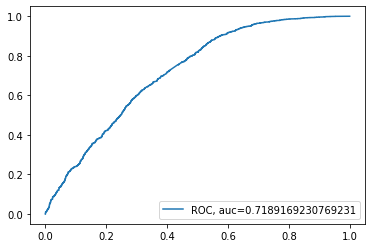

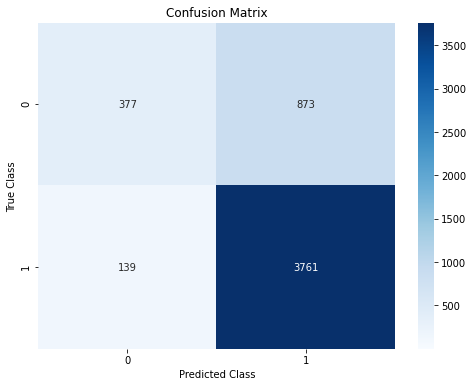

In [0]:
fig = plt.figure()
y_pred_proba = model.predict_proba(dfv3.drop(columns = 'TimeCycle'))[::,1]
fpr, tpr, _ = metrics.roc_curve(dfv3['TimeCycle'],y_pred_proba)
auc = metrics.roc_auc_score(dfv3['TimeCycle'], y_pred_proba)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.show()
fig.savefig(dest+'ROC.png', dpi=fig.dpi)

cm = metrics.confusion_matrix(dfv3['TimeCycle'],result)
# labels = ['No Default', 'Default']
fig = plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
fig.savefig(dest+'Confusion Matrix.png', dpi=fig.dpi)

## Plotting shap plots to check positive or negetive quantities of effect of the individual features for the final prediction

### 1. Creating shap_values from validation data predictions

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dfv3.drop(columns = ['TimeCycle']))

### 2. Creating Summary of SHAP Values for Broad understanding of Impact of top Features

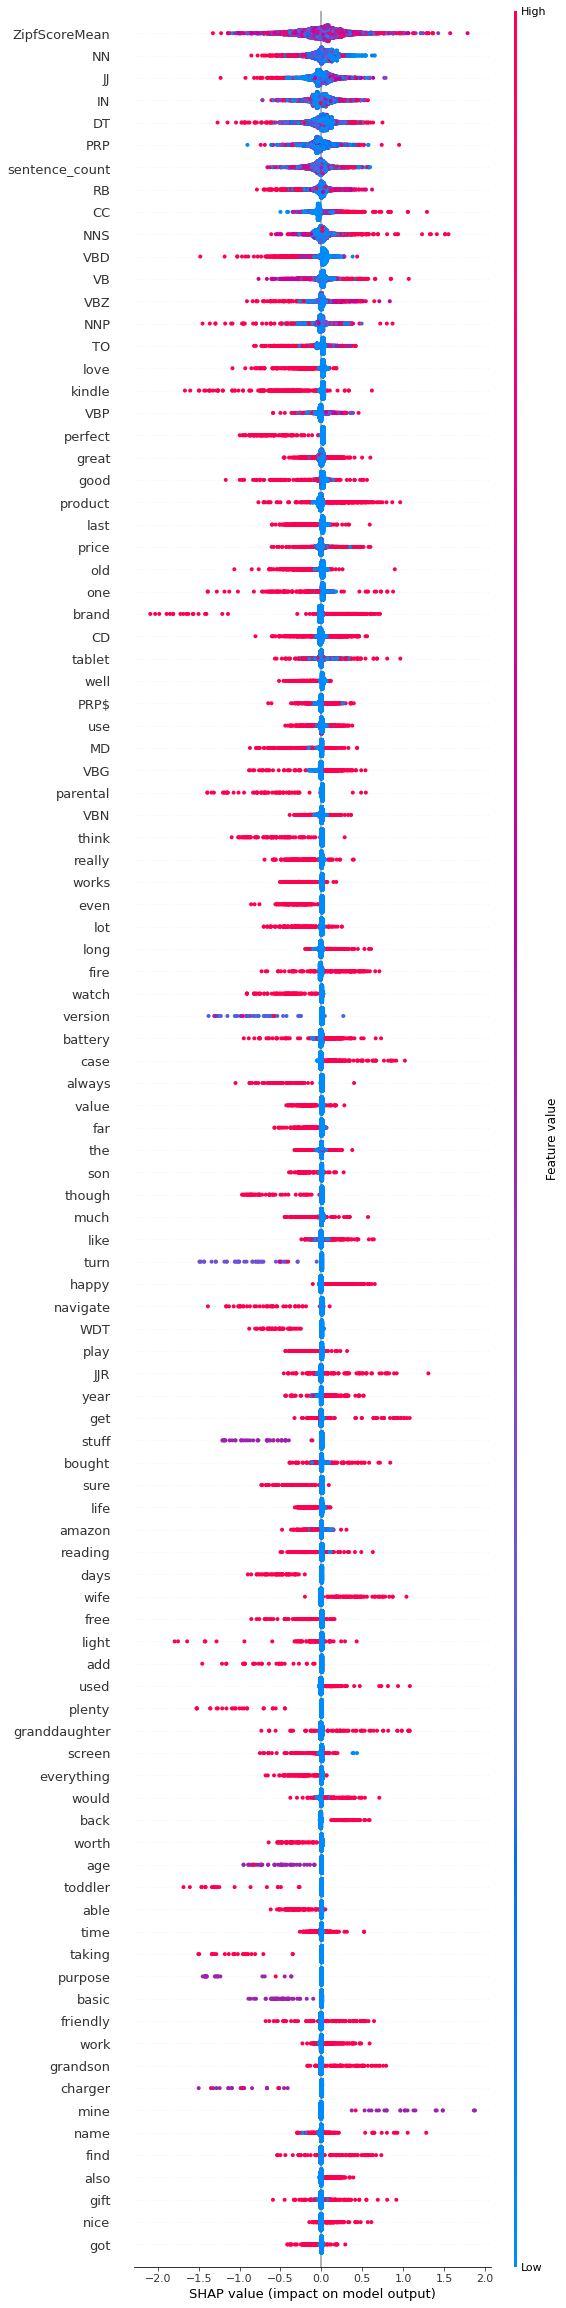

In [0]:
shap.summary_plot(shap_values[0], dfv3.drop(columns = ['TimeCycle']), max_display = 100) ## Change max_display value to add more features to the summary plot

### 3. Lets look at a single prediction to verify results from summary plot

#### First we draw a force plot and decision_plot

In [0]:
row_number = 31  ## Change to look a specific row of validation data. Can also give a range for clustered force plot.

shap.initjs()
shap.force_plot(base_value = explainer.expected_value[0], shap_values = shap_values[0][row_number], features = dfv3.drop(columns = ['TimeCycle']).iloc[row_number,:], feature_names = list(dfv3.columns[:-1]))

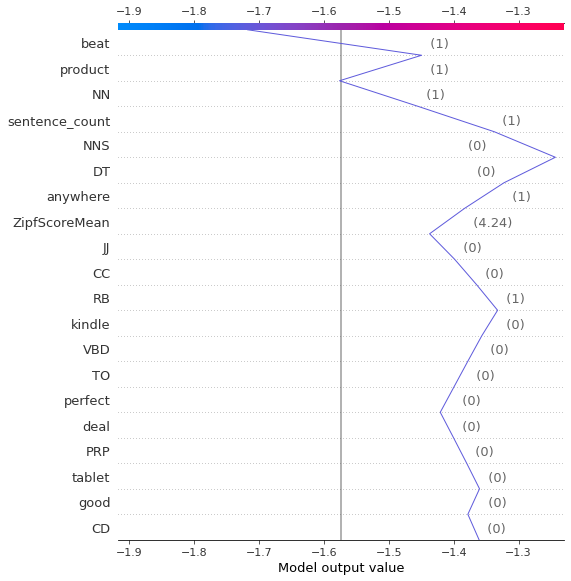

In [0]:
shap.decision_plot(base_value = explainer.expected_value[0], shap_values = shap_values[0][row_number],features = dfv3.drop(columns = ['TimeCycle']).iloc[row_number,:],feature_names = list(dfv3.columns[:-1]))

## Looking at Overall Model Feature Importances

Another way to look at importances apart from SHAP values.

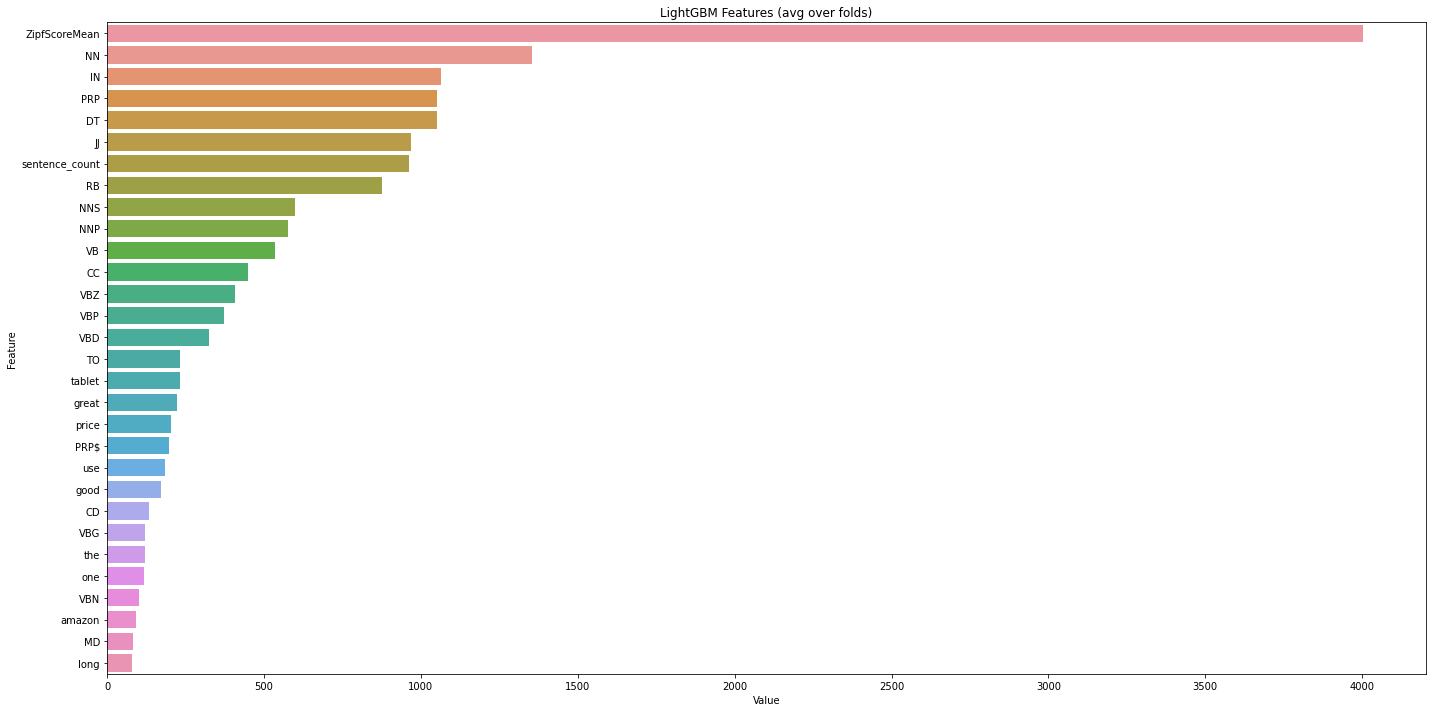

      Value         Feature
5173   4002   ZipfScoreMean
5172   1353              NN
5171   1064              IN
5170   1051             PRP
5169   1051              DT
5168    968              JJ
5167    963  sentence_count
5166    875              RB
5165    598             NNS
5164    576             NNP
5163    536              VB
5162    448              CC
5161    407             VBZ
5160    374             VBP
5159    324             VBD
5158    234              TO
5157    232          tablet
5156    224           great
5155    205           price
5154    198            PRP$
5153    186             use
5152    172            good
5151    134              CD
5149    122             VBG
5150    122             the
5148    119             one
5147    101             VBN
5146     91          amazon
5145     84              MD
5144     81            long


<Figure size 432x288 with 0 Axes>

In [0]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,model.feature_name_)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False)
feature_imp.to_csv(dest+'Importances.csv') ## Saved in session runtime. Can be seen in "Files" section in the margin on the left

feature_imp = feature_imp.head(30)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')

print(feature_imp.head(30))

## Point-Biscerial Correlations
Another way to look relation between continuous features and binary target

In [0]:
from scipy import stats

dft3 = dft3.dropna()

l = []
for i in dft3.drop(columns = 'TimeCycle'):
    m = list(stats.pointbiserialr(dft3[i], dft3["TimeCycle"]))
    n = list(stats.kruskal(dft3[i], dft3["TimeCycle"]))
    l2 = [m[0],m[1],n[0],n[1]]
    l2.append(i)
    l.append(l2)

df_corr = pd.DataFrame(l)
df_corr.columns = ['PB_Corr', 'PB_P.Value', 'kruskal_statistic','kruskal_P_Value','Column']
df_corr = df_corr.set_index('Column')
df_corr[((df_corr['kruskal_P_Value'] != 0.0) & (df_corr['kruskal_P_Value'] <= 0.05)) | (df_corr['PB_P.Value'] <= 0.05)].head()

,PB_Corr,PB_P.Value,kruskal_statistic,kruskal_P_Value
Column,,,,
absolute,-0.021664,0.000971,27960.271597,0.0
accent,-0.016215,0.013557,27983.314878,0.0
accident,-0.013555,0.039040,27969.012906,0.0
accidentally,-0.019715,0.002683,27836.994605,0.0
acting,-0.015317,0.019691,27975.631909,0.0


### Lets look at the histogram of correlations to understand strength and direction of correlations of all significantly correlated features

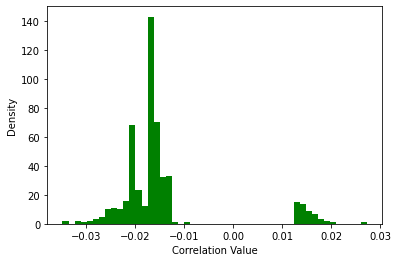

Number of significantly correlated features =  497

Top 100 significantly correlated features by correlation coefficient values



,PB_Corr,PB_P.Value,kruskal_statistic,kruskal_P_Value
Column,,,,
outside,-0.034728,1.230504e-07,27720.377789,0.0
lose,-0.033607,3.086558e-07,27884.638801,0.0
card,-0.031602,1.489645e-06,27120.845033,0.0
unless,-0.031210,2.005528e-06,27787.983532,0.0
boost,-0.030338,3.838354e-06,27964.110972,0.0
...,...,...,...,...
differentiate,-0.019859,2.496153e-03,27979.473159,0.0
reappearance,-0.019859,2.496153e-03,27979.473159,0.0
thinness,-0.019859,2.496153e-03,27979.473159,0.0


In [0]:
df_corr2 = df_corr[((df_corr['kruskal_P_Value'] != 0.0) & (df_corr['kruskal_P_Value'] <= 0.05)) | (df_corr['PB_P.Value'] <= 0.05)]
fig = plt.figure()
plt.hist(df_corr2['PB_Corr'], bins=50, color = 'g')
plt.xlabel('Correlation Value')
plt.ylabel('Density')
plt.show()
fig.savefig(dest+'fig5.png', dpi=fig.dpi)
print("Number of significantly correlated features = ",df_corr2.shape[0])

df_corr2['Correlation2'] = df_corr2['PB_Corr'].abs()
df_corr3 = df_corr2.sort_values('Correlation2', ascending = False).drop(columns = 'Correlation2')

print("\nTop 100 significantly correlated features by correlation coefficient values\n")
df_corr3.head(100)

In [0]:
df_corr3['weekday_mean'] = 0
df_corr3['weekday_max'] = 0
df_corr3['weekday_min'] = 0
df_corr3['weekend_mean'] = 0
df_corr3['weekend_max'] = 0
df_corr3['weekend_min'] = 0

for i in df_corr3.index:
  df_corr3.loc[i,'weekday_mean'] = dft3[dft3['TimeCycle'] == 1][i].mean()
  df_corr3.loc[i,'weekday_max'] = dft3[dft3['TimeCycle'] == 1][i].max()
  df_corr3.loc[i,'weekday_min'] = dft3[dft3['TimeCycle'] == 1][i].min()
  df_corr3.loc[i,'weekend_mean'] = dft3[dft3['TimeCycle'] == 0][i].mean()
  df_corr3.loc[i,'weekend_max'] = dft3[dft3['TimeCycle'] == 0][i].max()
  df_corr3.loc[i,'weekend_min'] = dft3[dft3['TimeCycle'] == 0][i].min()
  

df_corr3.to_csv('PB Corrs.csv')
df_corr3.head()

,PB_Corr,PB_P.Value,kruskal_statistic,kruskal_P_Value,weekday_mean,weekday_max,weekday_min,weekend_mean,weekend_max,weekend_min
Column,,,,,,,,,,
outside,-0.034728,1.230504e-07,27720.377789,0.0,0.001948,2,0,0.006459,1,0
lose,-0.033607,3.086558e-07,27884.638801,0.0,0.000516,1,0,0.003317,2,0
card,-0.031602,1.489645e-06,27120.845033,0.0,0.008250,3,0,0.016411,3,0
unless,-0.031210,2.005528e-06,27787.983532,0.0,0.001432,1,0,0.004888,1,0
boost,-0.030338,3.838354e-06,27964.110972,0.0,0.000000,0,0,0.001222,1,0


In [0]:
!cd content/

/bin/bash: line 0: cd: content/: No such file or directory
